# Applied

In [184]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

import statsmodels.api as sm
from ISLP import (load_data,
                  confusion_table)
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         contrast)
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## 13.

### (a)

In [185]:
Weekly = load_data('Weekly')
Weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [186]:
Weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [187]:
Weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


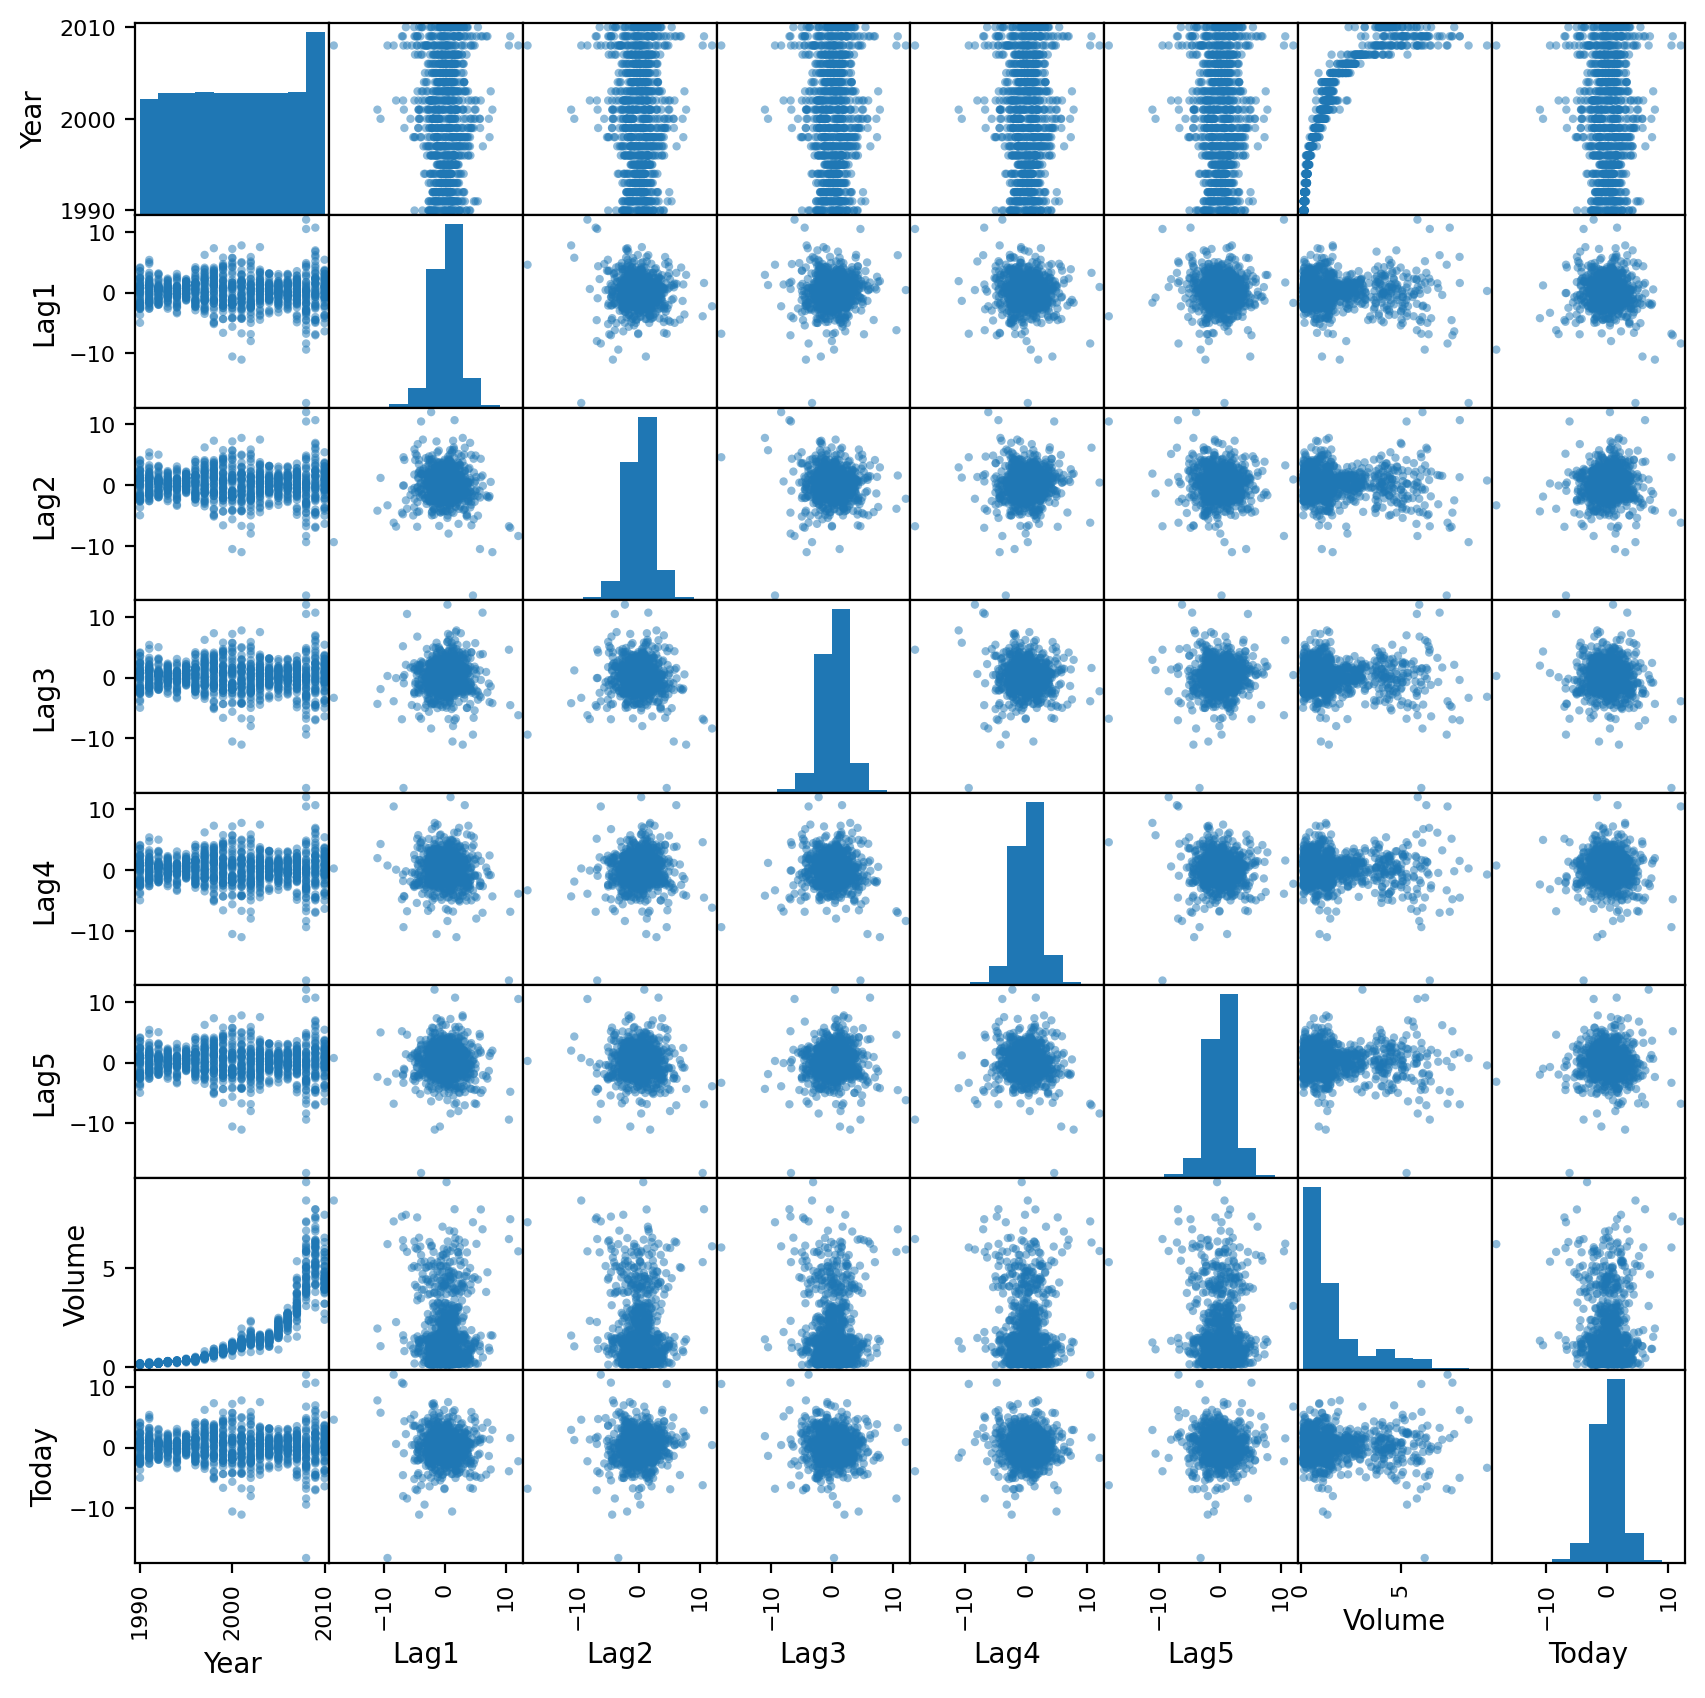

In [188]:
pd.plotting.scatter_matrix(Weekly, figsize=(10, 10));

Year and Volume has a strong positive relationship.

### (b)

In [189]:
Weekly['Direction'].value_counts()

Direction
Up      605
Down    484
Name: count, dtype: int64

In [190]:
features = Weekly.columns.drop(['Direction', 'Year', 'Today'])
y = Weekly['Direction'] == 'Up'
X = MS(features).fit_transform(Weekly)
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


Only Lag2 is significant predictor.

### (c)

In [191]:
pred = results.predict() > 0.5
confusion_table(pred, y)

Truth,False,True
Predicted,,
False,54,48
True,430,557


In [192]:
print('Prediction accuracy: {:.2%}'.format((pred==y).sum() / len(y)))

Prediction accuracy: 56.11%


In [193]:
605/(605+484)

0.5555555555555556

This logistic regression model has a high sensitivity but very low specificity. Also, its prediction accuracy is higher than 50%, but even if model predicts only 'Up', it could get prediction accuracy 55.6% which is close to 56%.

### (d)

In [194]:
train_idx = Weekly.Year <= 2008
X_train = X.loc[train_idx, ['Lag2']]
X_test = X.loc[~train_idx, ['Lag2']]
y_train = y.loc[train_idx]
y_test = y.loc[~train_idx]

In [195]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_prob = logit.predict_proba(X_test)
logit_pred = np.where(logit_prob[:,1] > 0.5, True, False)
confusion_table(logit_pred, y_test)

Truth,False,True
Predicted,,
False,9,5
True,34,56


In [196]:
print('Prediction accuracy: {:.2%}'.format((logit_pred==y_test).sum() / len(y_test)))

Prediction accuracy: 62.50%


### (e)

In [197]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [198]:
lda_pred = lda.predict(X_test)
confusion_table(lda_pred, y_test)

Truth,False,True
Predicted,,
False,9,5
True,34,56


In [199]:
print('Prediction accuracy: {:.2%}'.format((lda_pred==y_test).sum() / len(y_test)))

Prediction accuracy: 62.50%


### (f)

In [200]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [201]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, y_test)

Truth,False,True
Predicted,,
False,0,0
True,43,61


In [202]:
print('Prediction accuracy: {:.2%}'.format((qda_pred==y_test).sum() / len(y_test)))

Prediction accuracy: 58.65%


### (g)

In [203]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [204]:
knn_pred = knn1.predict(X_test)
confusion_table(knn_pred, y_test)

Truth,False,True
Predicted,,
False,21,30
True,22,31


In [205]:
print('Prediction accuracy: {:.2%}'.format((knn_pred==y_test).sum() / len(y_test)))

Prediction accuracy: 50.00%


### (h)

In [206]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [207]:
nb_pred = nb.predict(X_test)
confusion_table(nb_pred, y_test)

Truth,False,True
Predicted,,
False,0,0
True,43,61


In [208]:
print('Prediction accuracy: {:.2%}'.format((nb_pred==y_test).sum() / len(y_test)))

Prediction accuracy: 58.65%


### (i)

Based on test prediction accuracy, both LDA and logistic regression provide best results.

### (j)

In [209]:
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train, y_train)
knn2_pred = knn2.predict(X_test)
print('Prediction accuracy: {:.2%}'.format((knn2_pred==y_test).sum() / len(y_test)))
confusion_table(knn2_pred, y_test)

Prediction accuracy: 44.23%


Truth,False,True
Predicted,,
False,30,45
True,13,16


In [210]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
knn3_pred = knn3.predict(X_test)
print('Prediction accuracy: {:.2%}'.format((knn3_pred==y_test).sum() / len(y_test)))
confusion_table(knn3_pred, y_test)

Prediction accuracy: 55.77%


Truth,False,True
Predicted,,
False,16,19
True,27,42


In [211]:
knn4 = KNeighborsClassifier(n_neighbors=4)
knn4.fit(X_train, y_train)
knn4_pred = knn4.predict(X_test)
print('Prediction accuracy: {:.2%}'.format((knn4_pred==y_test).sum() / len(y_test)))
confusion_table(knn4_pred, y_test)

Prediction accuracy: 57.69%


Truth,False,True
Predicted,,
False,26,27
True,17,34


In [212]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
knn5_pred = knn5.predict(X_test)
print('Prediction accuracy: {:.2%}'.format((knn5_pred==y_test).sum() / len(y_test)))
confusion_table(knn5_pred, y_test)

Prediction accuracy: 52.88%


Truth,False,True
Predicted,,
False,15,21
True,28,40


## 14.

In [213]:
Auto = load_data('Auto')
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


### (a)

In [214]:
med = Auto.mpg.median()
med

22.75

In [215]:
mpg01 = np.where(Auto.mpg > med, 1, 0)
Auto['mpg01'] = mpg01
Auto['mpg01'].value_counts()

mpg01
0    196
1    196
Name: count, dtype: int64

### (b)

/var/folders/7p/wd46twpj5yj_sg6typcw5pvm0000gn/T/ipykernel_24116/4048970491.py:2: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  Auto.boxplot(ax=axes, by='mpg01');


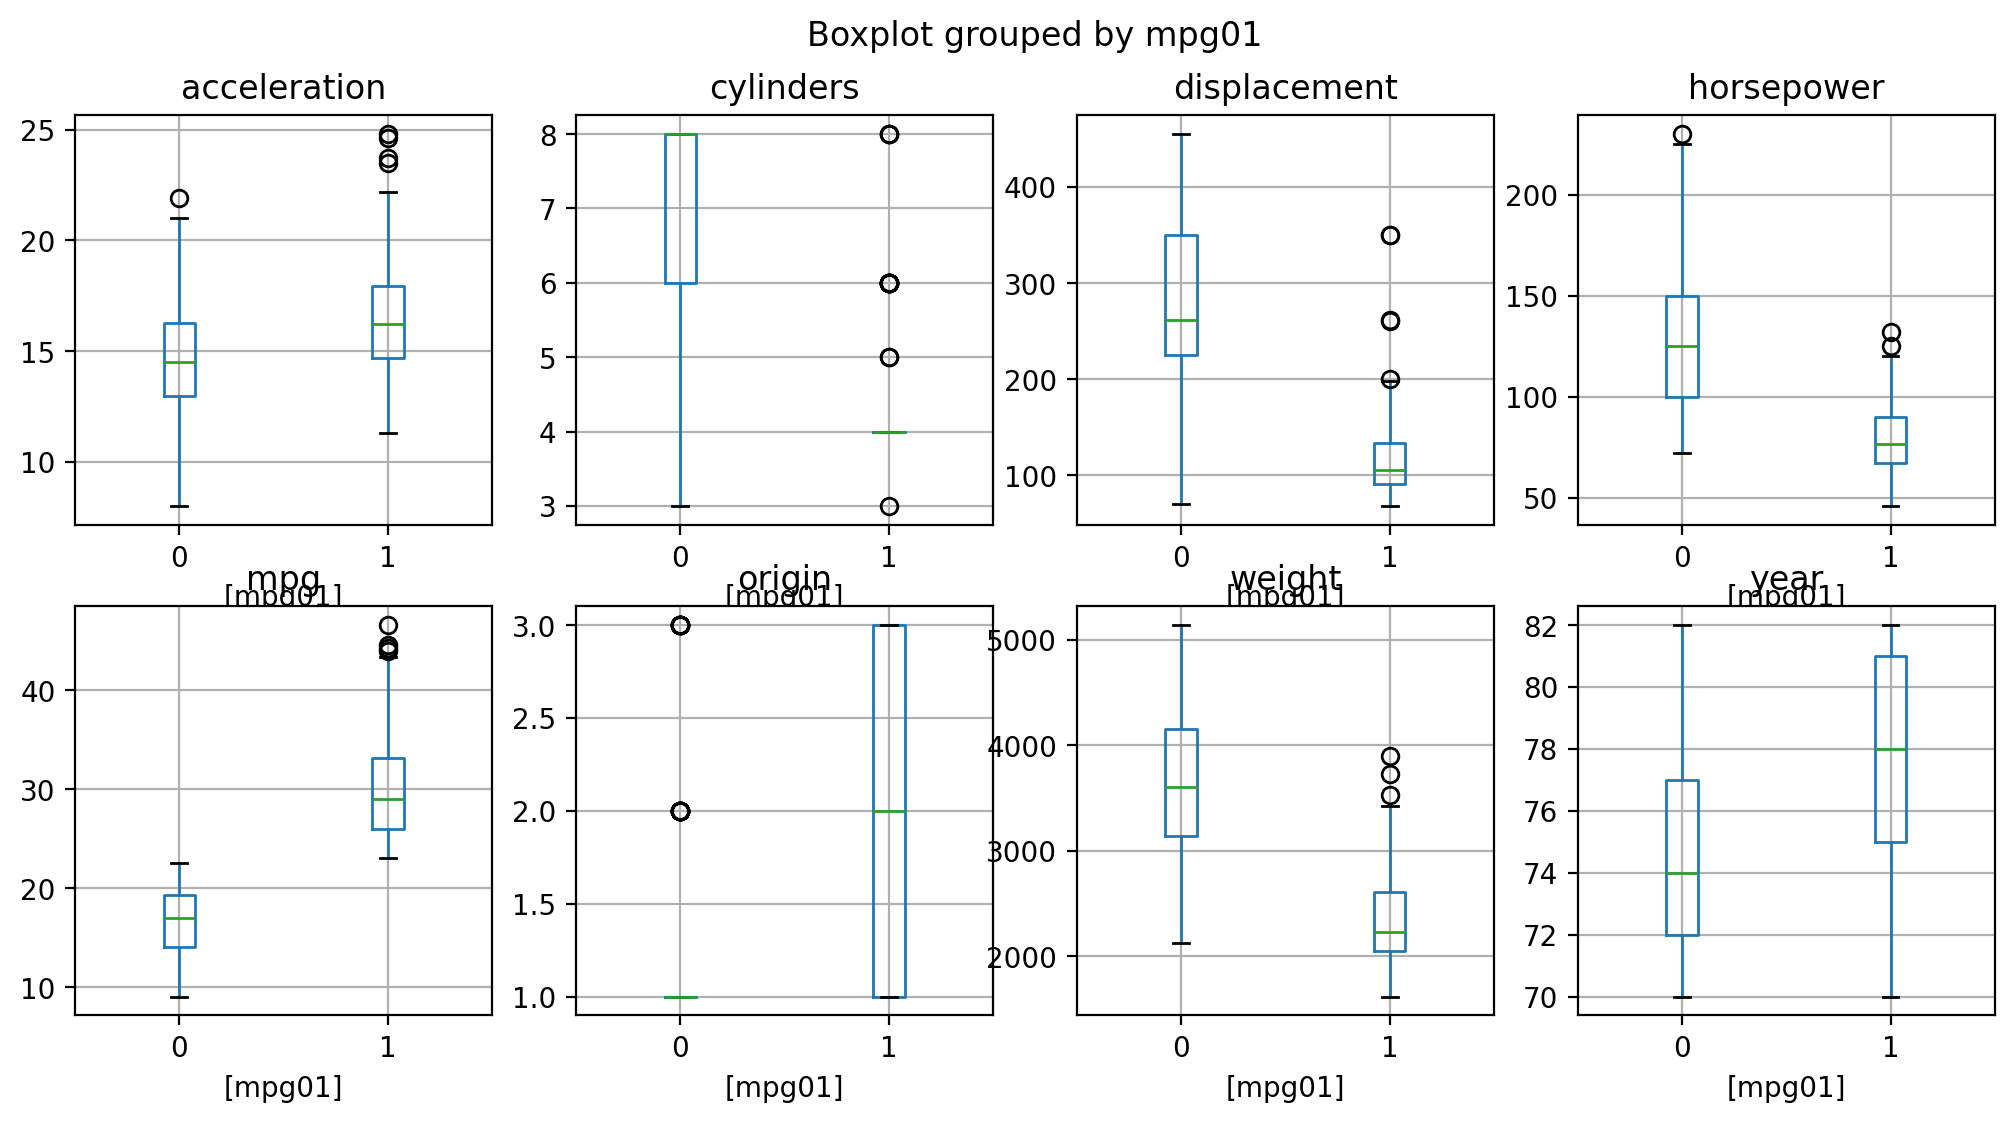

In [216]:
fig, axes = subplots(nrows=2, ncols=4, figsize=(12, 6), sharey=False)
Auto.boxplot(ax=axes, by='mpg01');

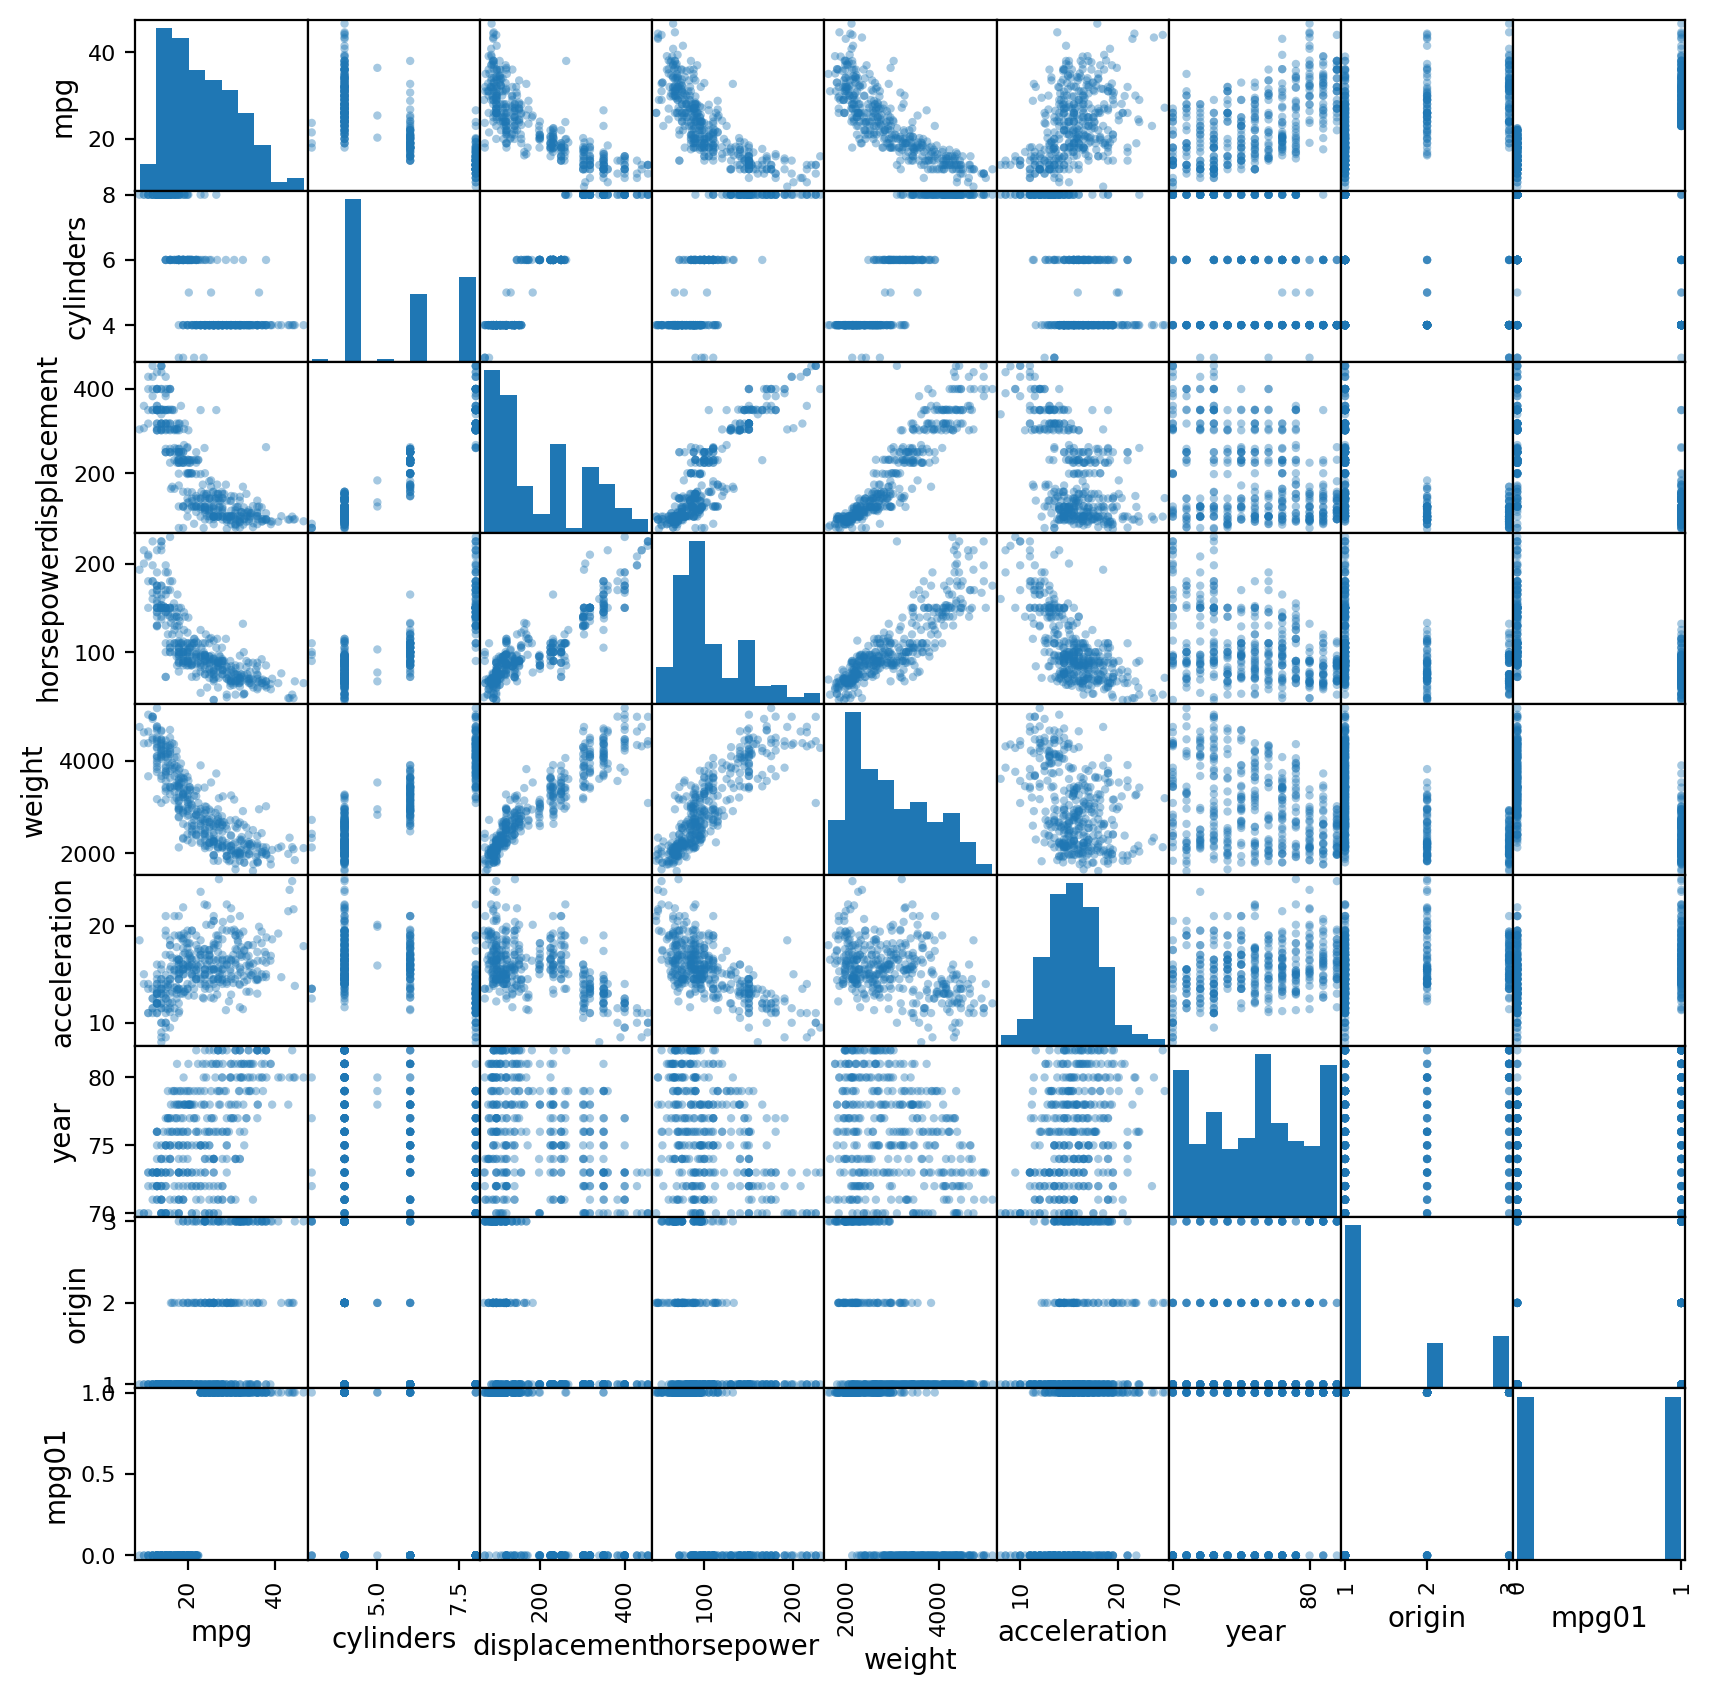

In [217]:
pd.plotting.scatter_matrix(Auto, alpha=0.4, figsize=(10, 10));

Horsepower has the smallest overlap when grouped by mpg01.

### (c)

In [218]:
y = Auto.mpg01
X = Auto.loc[:,['horsepower']]
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=80, random_state=0)

### (d)

In [219]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [220]:
lda_pred = lda.predict(X_test)
print('test error: {0:.2%}'.format((lda_pred != y_test).sum()/len(y_test)))
confusion_table(lda_pred, y_test)

test error: 16.25%


Truth,0,1
Predicted,,
0,30,1
1,12,37


### (e)

In [221]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [222]:
qda_pred = qda.predict(X_test)
print('test error: {0:.2%}'.format((qda_pred != y_test).sum()/len(y_test)))
confusion_table(qda_pred, y_test)

test error: 16.25%


Truth,0,1
Predicted,,
0,30,1
1,12,37


### (f)

In [223]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)

LogisticRegression(C=10000000000.0, solver='liblinear')

In [224]:
logit_pred = logit.predict(X_test)
print('test error: {0:.2%}'.format((logit_pred != y_test).sum()/len(y_test)))
confusion_table(logit_pred, y_test)

test error: 13.75%


Truth,0,1
Predicted,,
0,32,1
1,10,37


### (g)

In [225]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [226]:
nb_pred = nb.predict(X_test)
print('test error: {0:.2%}'.format((nb_pred != y_test).sum()/len(y_test)))
confusion_table(nb_pred, y_test)

test error: 16.25%


Truth,0,1
Predicted,,
0,30,1
1,12,37


### (h)

In [227]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
knn1_pred = knn1.predict(X_test)
print('test error: {0:.2%}'.format((knn1_pred != y_test).sum()/len(y_test)))
confusion_table(knn1_pred, y_test)

test error: 15.00%


Truth,0,1
Predicted,,
0,32,2
1,10,36


In [228]:
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train, y_train)
knn2_pred = knn2.predict(X_test)
print('test error: {0:.2%}'.format((knn2_pred != y_test).sum()/len(y_test)))
confusion_table(knn2_pred, y_test)

test error: 11.25%


Truth,0,1
Predicted,,
0,36,3
1,6,35


In [229]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
knn3_pred = knn3.predict(X_test)
print('test error: {0:.2%}'.format((knn3_pred != y_test).sum()/len(y_test)))
confusion_table(knn3_pred, y_test)

test error: 15.00%


Truth,0,1
Predicted,,
0,32,2
1,10,36


In [230]:
knn4 = KNeighborsClassifier(n_neighbors=4)
knn4.fit(X_train, y_train)
knn4_pred = knn4.predict(X_test)
print('test error: {0:.2%}'.format((knn4_pred != y_test).sum()/len(y_test)))
confusion_table(knn4_pred, y_test)

test error: 13.75%


Truth,0,1
Predicted,,
0,34,3
1,8,35


In [231]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train, y_train)
knn5_pred = knn5.predict(X_test)
print('test error: {0:.2%}'.format((knn5_pred != y_test).sum()/len(y_test)))
confusion_table(knn5_pred, y_test)

test error: 13.75%


Truth,0,1
Predicted,,
0,32,1
1,10,37


K = 2 is the best.

## 15.

### (a)

In [232]:
def Power():
    print(2**3)

In [233]:
Power()

8


### (b)

In [234]:
def Power2(x, a):
    print(x**a)

In [235]:
Power2(3, 8)

6561


### (c)

In [236]:
Power2(10, 3)

1000


In [237]:
Power2(8, 17)

2251799813685248


In [238]:
Power2(131, 3)

2248091


### (d)

In [239]:
def Power3(x, a):
    return x**a

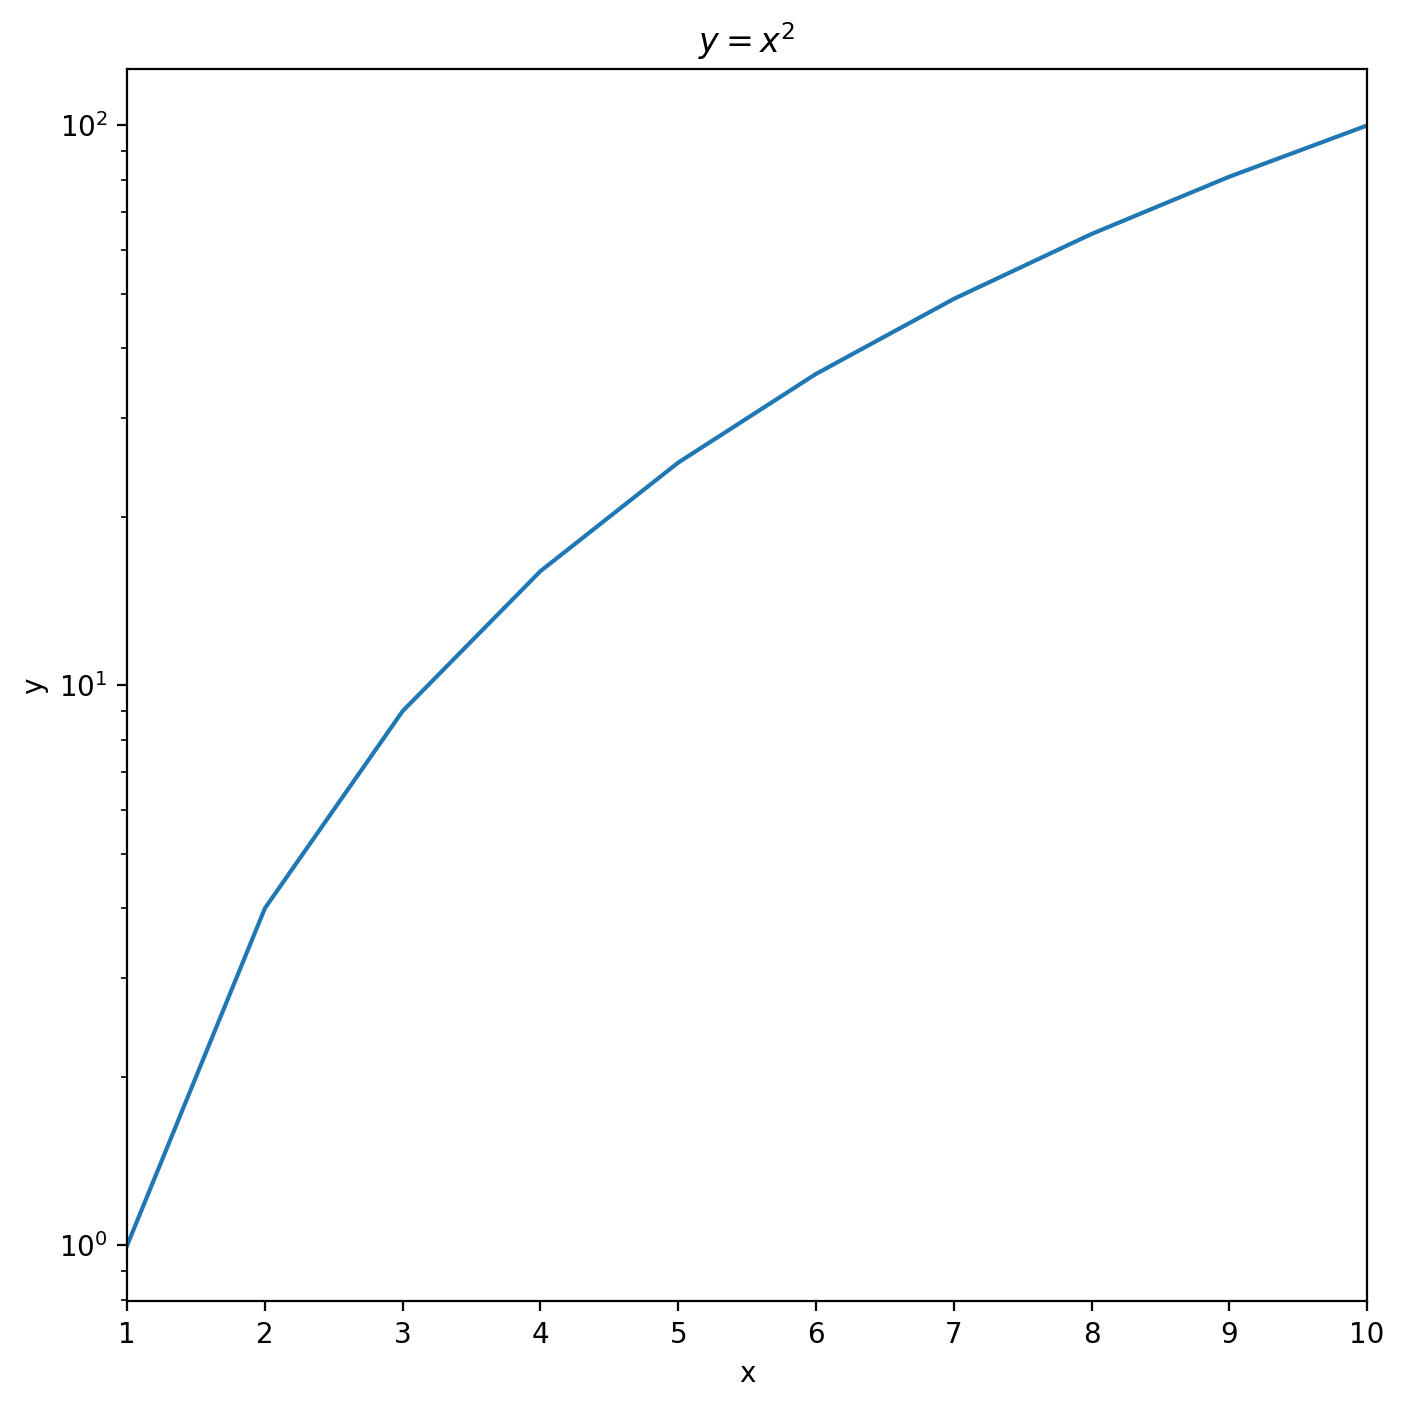

In [240]:
x = np.arange(1, 11, 1)
y = Power3(x, 2)
fig, ax = subplots(figsize=(8, 8))
ax.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(1, 10)
ax.set_title('$y = x^2$')
# ax.set_xscale('log')
ax.set_yscale('log')

### (f)

In [241]:
def PlotPower(x, a, **kwargs):
    y = x**a
    _, ax = subplots(**kwargs)
    ax.plot(x, y)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('$y = x^{}$'.format(a))

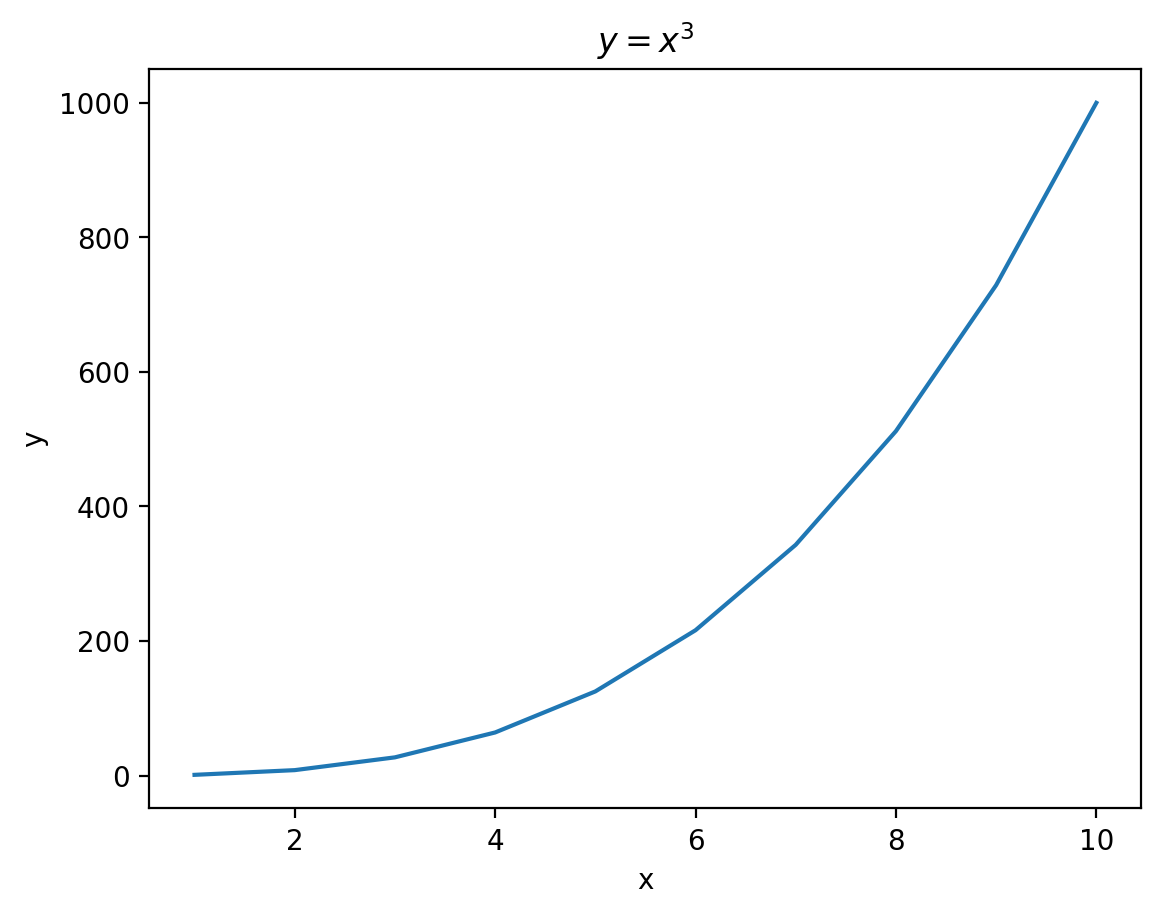

In [242]:
PlotPower(np.arange(1, 11), 3)